# Conditional GAN with MNIST

* MNIST data를 가지고 **Conditional GAN**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)
* based on dcgan

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

tf.set_random_seed(219)
np.random.seed(219)

os.environ["CUDA_VISIBLE_DEVICES"]="2"

/home/lab4all/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FLAGS = tf.app.flags.FLAGS

# Training Flags
tf.app.flags.DEFINE_string('train_dir', 'train/cgan_based_on_dcgan/exp1', '')
tf.app.flags.DEFINE_integer('max_epochs', 50, '')
tf.app.flags.DEFINE_integer('save_epochs', 5, '')
tf.app.flags.DEFINE_integer('summary_steps', 2500, '')
tf.app.flags.DEFINE_integer('print_steps', 1000, '')
tf.app.flags.DEFINE_integer('batch_size', 64, '')
tf.app.flags.DEFINE_float('learning_rate_D', 0.0002, '')
tf.app.flags.DEFINE_float('learning_rate_G', 0.001, '')
tf.app.flags.DEFINE_integer('k', 1, 'the number of step of learing D before learning G')

## Import MNIST

In [3]:
data_dir = 'mnist'
mnist = input_data.read_data_sets(data_dir, one_hot=True)
num_examples = len(mnist.train.images)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


## Create the model

In [4]:
class CGAN_model(object):
  """Conditional Generative Adversarial Networks
  implementation based on http://arxiv.org/abs/1411.1784
  
  "Conditional Generative Adversarial Nets"
  Mehdi Mirza, Simon Osindero
  """
  
  def __init__(self, mode):
    """Basic setup.
    
    Args:
      mode: "train" or "generate"
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 784
    self.z_dim = 100
    self.y_dim = 10 # for MNIST 
    self.batch_size = FLAGS.batch_size
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_inputs(self):
    """Build random_z + condition
    
    Returns:
      A float32 Tensor with [batch_size, z_dim]
    """
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      self.random_z = tf.placeholder(tf.float32, [None, self.z_dim])
      
    # Setup placeholder of condition
    with tf.variable_scope('condition'):
      self.condition = tf.placeholder(tf.float32, [None, self.y_dim])

    return self.random_z, self.condition
  
  
  def read_MNIST(self):
    # Setup placeholder of real data (MNIST)
    with tf.variable_scope('mnist'):
      self.mnist = tf.placeholder(tf.float32, [None, self.x_dim])
      self.mnist_image = tf.reshape(self.mnist, [-1, 28, 28, 1])
      self.labels = tf.placeholder(tf.float32, [None, self.y_dim])
      
      return self.mnist_image, self.labels


  def Generator(self, random_z, condition, is_training=True, reuse=False):
    """Generator setup.
    
    Args:
      random_z: A float32 Tensor random vector [batch_size, z_dim] (latent code)
      is_training: boolean whether training mode or generating mode
      condition: A float32 Tensor [batch_size, y_dim] for conditio vector (one-hot)
      reuse: variables reuse flag
      
    Returns:
      A float32 scalar Tensor of generated images from random vector
    """
    with tf.variable_scope('Generator') as scope:
      if reuse:
        scope.reuse_variables()
        
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'is_training': is_training,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):

        # Use full conv2d_transpose instead of projection and reshape
        # inputs = random_z: 100 dim
        self.concat = tf.concat([random_z, condition], axis=1)
        self.inputs = tf.reshape(self.concat, [-1, 1, 1, self.z_dim + self.y_dim])
        # inputs = random_z + condition : 1 x 1 x (100 + 10) dim
        self.layer1 = slim.conv2d_transpose(inputs=self.inputs,
                                            num_outputs=256,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer1')
        # layer1: 3 x 3 x 256 dim
        self.layer2 = slim.conv2d_transpose(inputs=self.layer1,
                                            num_outputs=128,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer2')
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d_transpose(inputs=self.layer2,
                                            num_outputs=64,
                                            scope='layer3')
        # layer3: 14 x 14 x 64 dim
        self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                            num_outputs=1,
                                            normalizer_fn=None,
                                            activation_fn=tf.sigmoid,
                                            scope='layer4')
        # output = layer4: 28 x 28 x 1 dim
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, condition, reuse=False):
    """Discriminator setup.
    
    Args:
      data: A float32 scalar Tensor of real data
      condition: A float32 Tensor [batch_size, y_dim] for conditio vector (one-hot)
      reuse: variables reuse flag
      
    Returns:
      logits: A float32 scalar Tensor
    """
    with tf.variable_scope('Discriminator') as scope:
      if reuse:
        scope.reuse_variables()
        
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        
        # data: 28 x 28 x 1 dim
        # condition: 10 dim (for MNIST)
        condition = tf.reshape(condition, [-1, 1, 1, self.y_dim])
        self.inputs = tf.concat([data, condition * tf.ones([self.batch_size, 28, 28, self.y_dim])], axis=3)

        # inputs: 28 x 28 x (1 + 10) dim
        self.layer1 = slim.conv2d(inputs=self.inputs,
                                  num_outputs=64,
                                  normalizer_fn=None,
                                  scope='layer1')
        # layer1: 14 x 14 x 64 dim
        self.layer2 = slim.conv2d(inputs=self.layer1,
                                  num_outputs=128,
                                  scope='layer2')
        # layer2: 7 x 7 x 128 dim
        self.layer3 = slim.conv2d(inputs=self.layer2,
                                  num_outputs=256,
                                  kernel_size=[3, 3],
                                  padding='VALID',
                                  scope='layer3')
        # layer3: 3 x 3 x 256 dim
        self.layer4 = slim.conv2d(inputs=self.layer3,
                                  num_outputs=1,
                                  kernel_size=[3, 3],
                                  stride=[1, 1],
                                  padding='VALID',
                                  normalizer_fn=None,
                                  activation_fn=None,
                                  scope='layer4')
        # logits = layer4: 1 x 1 x 1 dim
        discriminator_logits = tf.squeeze(self.layer4, axis=[2, 3])

        return discriminator_logits
    
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      self.global_step = tf.Variable(initial_value=0,
                                     name='global_step',
                                     trainable=False,
                                     collections=[tf.GraphKeys.GLOBAL_STEP,
                                                  tf.GraphKeys.GLOBAL_VARIABLES])
      
      print('complete setup global_step.')
      
      
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits: A float32 Tensor of logits.
      is_real: boolean, Treu means `1` labeling, False means `0` labeling.
      
    Returns:
      A scalar Tensor representing the loss value.
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z, self.condition = self.build_inputs()
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z, self.condition)
      
      # read dataset
      self.real_data, self.real_labels = self.read_MNIST()
      
      # discriminating real data by Discriminator()
      self.real_logits = self.Discriminator(self.real_data, self.real_labels)
      # discriminating fake data (generated_images) by Discriminator()
      self.fake_logits = self.Discriminator(self.generated_data, self.condition, reuse=True)
      
      # losses of real with label "1"
      self.loss_real = self.GANLoss(logits=self.real_logits, is_real=True, scope='loss_D_real')
      # losses of fake with label "0"
      self.loss_fake = self.GANLoss(logits=self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # losses of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
      # losses of Generator with label "1" that used to fool the Discriminator
      self.loss_Generator = self.GANLoss(logits=self.fake_logits, is_real=True, scope='loss_G')
      
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      
      
      # generating images for sample
      self.sample_data = self.Generator(self.random_z, self.condition, is_training=False, reuse=True)

      # write summaries
      # Add loss summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      
      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
        
      # Add image summaries
      tf.summary.image('random_images', tf.reshape(self.generated_data, [-1, 28, 28, 1]), max_outputs=4)
      #tf.summary.image('real_images', tf.reshape(self.real_data, [-1, 28, 28, 1]))
      
    print('complete model build.\n')

## Define plot function

In [5]:
def print_sample_data(sample_data, max_print=10):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

## Build a model

In [6]:
model = CGAN_model(mode="train")
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 3x3x256x110) [253440, bytes: 1013760]
Generator/layer1/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
Generator/layer2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Generator/layer4/biases:0 (float32_ref 1) [1, bytes: 4]
Discriminator/layer1/weights:0 (float32_ref 4x4x11x64) [11264, bytes: 45056]
Discriminator/layer1/biases:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_ref 12

(1120898, 4483592)

In [7]:
opt_D = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_D, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate_G, beta1=0.5)

In [8]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
  opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
  opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)

In [9]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

summary_op = tf.summary.merge_all()

sv = tf.train.Supervisor(logdir=FLAGS.train_dir,
                         summary_op=None,
                         saver=saver,
                         save_model_secs=0,
                         init_fn=None)

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Start Session.
Epochs: 1.16 global_step: 1000  loss_D: 1.39693  loss_G: 0.810068 (5060.6 examples/sec; 0.01 sec/batch)


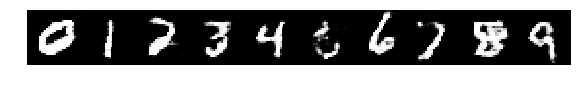

Epochs: 2.33 global_step: 2000  loss_D: 1.36997  loss_G: 0.822685 (4953.7 examples/sec; 0.01 sec/batch)


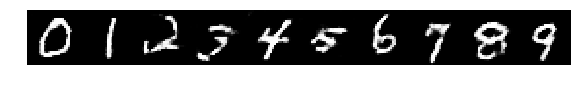

Epochs: 3.49 global_step: 3000  loss_D: 1.40881  loss_G: 0.72135 (5028.0 examples/sec; 0.01 sec/batch)


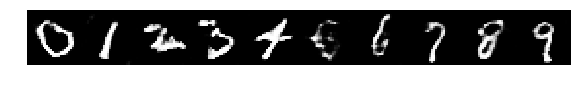

Epochs: 4.66 global_step: 4000  loss_D: 1.3997  loss_G: 0.758511 (4822.3 examples/sec; 0.01 sec/batch)


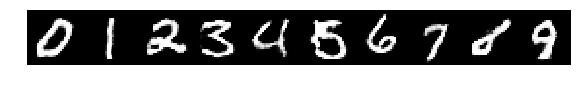

INFO:tensorflow:Saving model with global step 4296 (= 5 epochs) to disk.
Epochs: 5.82 global_step: 5000  loss_D: 1.37427  loss_G: 0.74342 (4829.5 examples/sec; 0.01 sec/batch)


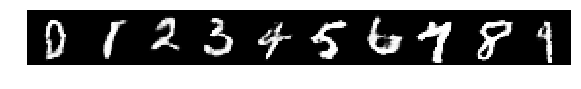

Epochs: 6.98 global_step: 6000  loss_D: 1.35982  loss_G: 0.713122 (4782.7 examples/sec; 0.01 sec/batch)


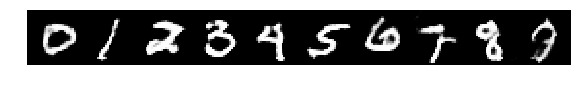

Epochs: 8.15 global_step: 7000  loss_D: 1.35817  loss_G: 0.753502 (4771.1 examples/sec; 0.01 sec/batch)


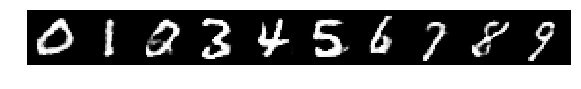

Epochs: 9.31 global_step: 8000  loss_D: 1.37437  loss_G: 0.717225 (4576.8 examples/sec; 0.01 sec/batch)


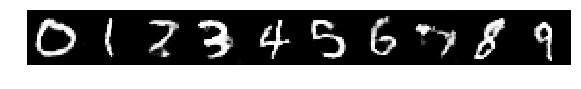

INFO:tensorflow:Saving model with global step 8591 (= 10 epochs) to disk.
INFO:tensorflow:global_step/sec: 73.6416
Epochs: 10.48 global_step: 9000  loss_D: 1.38301  loss_G: 0.712893 (4826.8 examples/sec; 0.01 sec/batch)


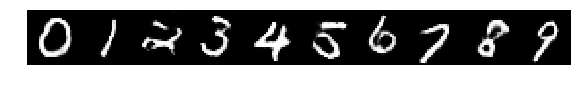

Epochs: 11.64 global_step: 10000  loss_D: 1.38244  loss_G: 0.735908 (4227.3 examples/sec; 0.02 sec/batch)


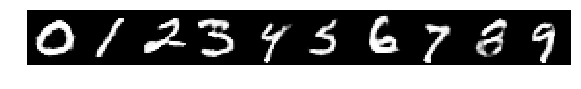

Epochs: 12.80 global_step: 11000  loss_D: 1.38375  loss_G: 0.709231 (4714.0 examples/sec; 0.01 sec/batch)


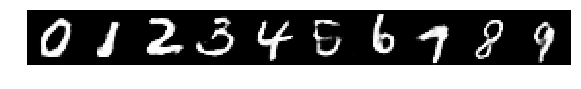

Epochs: 13.97 global_step: 12000  loss_D: 1.36386  loss_G: 0.729907 (4742.8 examples/sec; 0.01 sec/batch)


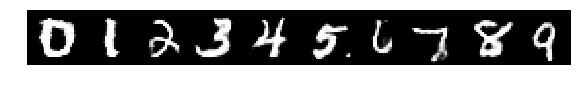

INFO:tensorflow:Saving model with global step 12886 (= 15 epochs) to disk.
Epochs: 15.13 global_step: 13000  loss_D: 1.38919  loss_G: 0.726192 (4808.9 examples/sec; 0.01 sec/batch)


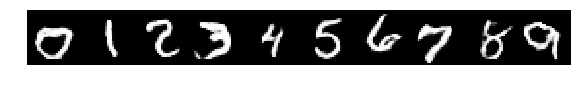

Epochs: 16.30 global_step: 14000  loss_D: 1.37689  loss_G: 0.711858 (4831.8 examples/sec; 0.01 sec/batch)


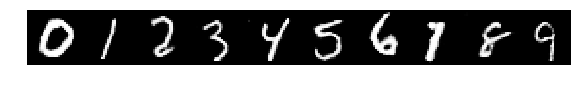

Epochs: 17.46 global_step: 15000  loss_D: 1.40054  loss_G: 0.752277 (4689.3 examples/sec; 0.01 sec/batch)


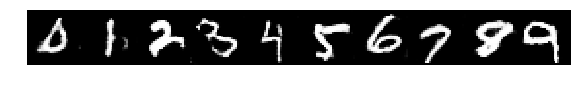

Epochs: 18.62 global_step: 16000  loss_D: 1.39123  loss_G: 0.753197 (4674.9 examples/sec; 0.01 sec/batch)


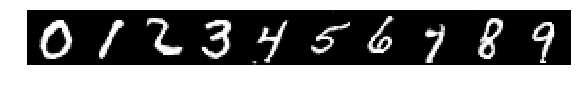

Epochs: 19.79 global_step: 17000  loss_D: 1.38584  loss_G: 0.722599 (4578.1 examples/sec; 0.01 sec/batch)


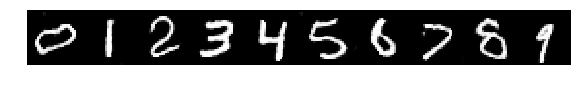

INFO:tensorflow:Saving model with global step 17181 (= 20 epochs) to disk.
INFO:tensorflow:global_step/sec: 71.8833
Epochs: 20.95 global_step: 18000  loss_D: 1.33035  loss_G: 0.771322 (4744.3 examples/sec; 0.01 sec/batch)


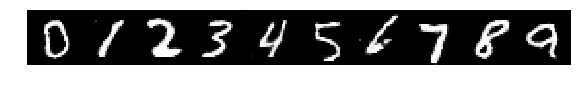

Epochs: 22.12 global_step: 19000  loss_D: 1.35756  loss_G: 0.985587 (4795.9 examples/sec; 0.01 sec/batch)


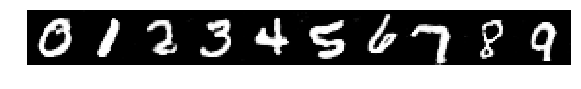

Epochs: 23.28 global_step: 20000  loss_D: 1.2681  loss_G: 0.824854 (4271.8 examples/sec; 0.01 sec/batch)


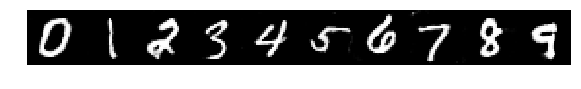

Epochs: 24.45 global_step: 21000  loss_D: 1.30343  loss_G: 0.791821 (4599.3 examples/sec; 0.01 sec/batch)


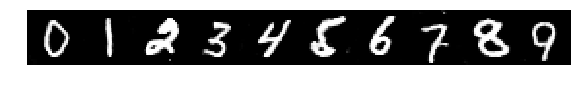

INFO:tensorflow:Saving model with global step 21476 (= 25 epochs) to disk.
Epochs: 25.61 global_step: 22000  loss_D: 1.2783  loss_G: 1.41504 (4521.0 examples/sec; 0.01 sec/batch)


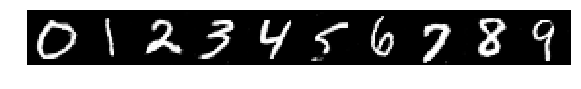

Epochs: 26.77 global_step: 23000  loss_D: 1.30883  loss_G: 0.933431 (4701.6 examples/sec; 0.01 sec/batch)


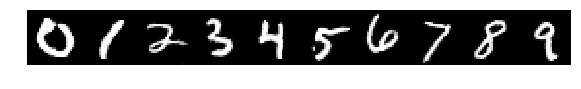

Epochs: 27.94 global_step: 24000  loss_D: 1.39631  loss_G: 1.07429 (4472.0 examples/sec; 0.01 sec/batch)


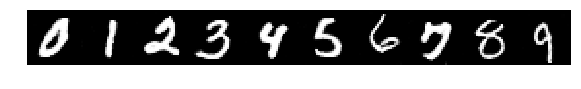

Epochs: 29.10 global_step: 25000  loss_D: 1.49807  loss_G: 1.22545 (4517.4 examples/sec; 0.01 sec/batch)


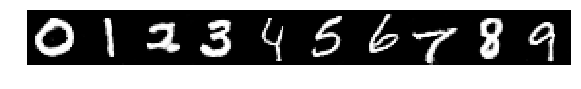

INFO:tensorflow:Saving model with global step 25771 (= 30 epochs) to disk.
INFO:tensorflow:global_step/sec: 70.5499
Epochs: 30.27 global_step: 26000  loss_D: 1.28489  loss_G: 0.997001 (4904.7 examples/sec; 0.01 sec/batch)


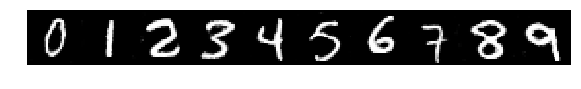

Epochs: 31.43 global_step: 27000  loss_D: 1.29563  loss_G: 0.935329 (4578.9 examples/sec; 0.01 sec/batch)


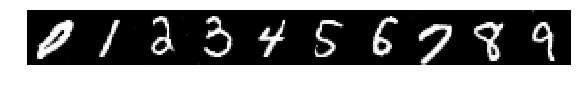

Epochs: 32.59 global_step: 28000  loss_D: 1.35872  loss_G: 1.17107 (4658.1 examples/sec; 0.01 sec/batch)


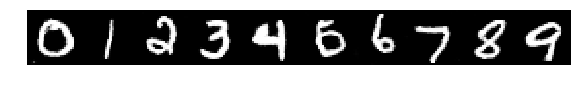

Epochs: 33.76 global_step: 29000  loss_D: 1.15  loss_G: 1.31821 (4703.4 examples/sec; 0.01 sec/batch)


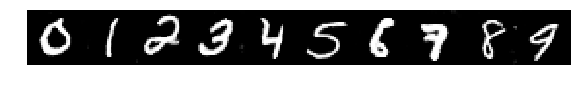

Epochs: 34.92 global_step: 30000  loss_D: 1.24812  loss_G: 1.21577 (4559.9 examples/sec; 0.01 sec/batch)


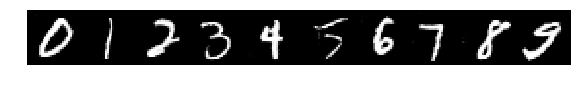

INFO:tensorflow:Saving model with global step 30066 (= 35 epochs) to disk.
Epochs: 36.09 global_step: 31000  loss_D: 1.37159  loss_G: 0.993217 (4619.0 examples/sec; 0.01 sec/batch)


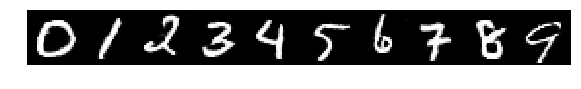

Epochs: 37.25 global_step: 32000  loss_D: 1.19027  loss_G: 1.42526 (4409.5 examples/sec; 0.01 sec/batch)


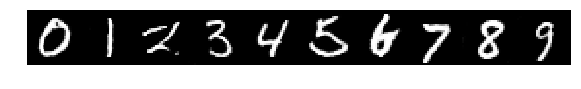

Epochs: 38.42 global_step: 33000  loss_D: 1.24843  loss_G: 1.22575 (4517.7 examples/sec; 0.01 sec/batch)


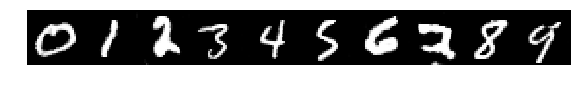

Epochs: 39.58 global_step: 34000  loss_D: 1.24292  loss_G: 0.877264 (4660.4 examples/sec; 0.01 sec/batch)


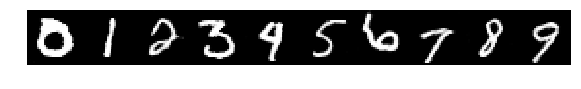

INFO:tensorflow:Saving model with global step 34361 (= 40 epochs) to disk.
INFO:tensorflow:global_step/sec: 70.2547
Epochs: 40.74 global_step: 35000  loss_D: 1.16492  loss_G: 1.02653 (4560.3 examples/sec; 0.01 sec/batch)


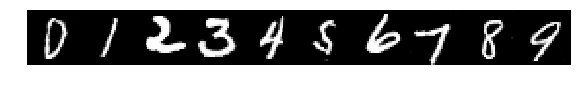

Epochs: 41.91 global_step: 36000  loss_D: 1.14593  loss_G: 1.07837 (4469.5 examples/sec; 0.01 sec/batch)


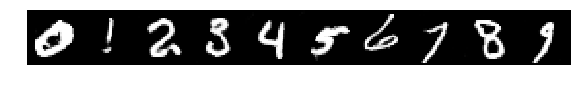

Epochs: 43.07 global_step: 37000  loss_D: 1.13065  loss_G: 1.21112 (4926.2 examples/sec; 0.01 sec/batch)


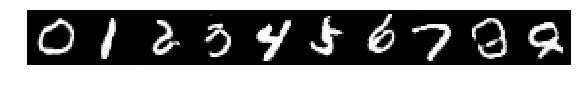

Epochs: 44.24 global_step: 38000  loss_D: 1.20954  loss_G: 1.38794 (4486.1 examples/sec; 0.01 sec/batch)


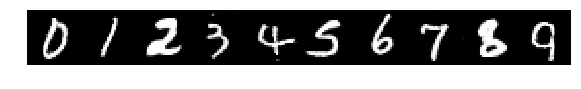

INFO:tensorflow:Saving model with global step 38656 (= 45 epochs) to disk.
Epochs: 45.40 global_step: 39000  loss_D: 1.15118  loss_G: 1.2444 (4415.4 examples/sec; 0.01 sec/batch)


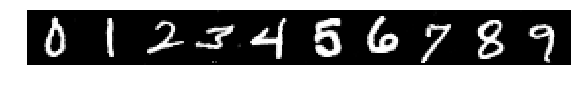

Epochs: 46.56 global_step: 40000  loss_D: 1.10279  loss_G: 1.03672 (4442.8 examples/sec; 0.01 sec/batch)


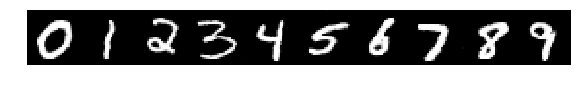

Epochs: 47.73 global_step: 41000  loss_D: 1.16306  loss_G: 0.989254 (4571.8 examples/sec; 0.01 sec/batch)


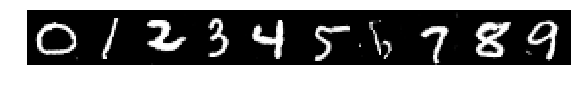

Epochs: 48.89 global_step: 42000  loss_D: 1.17482  loss_G: 1.48303 (4266.6 examples/sec; 0.02 sec/batch)


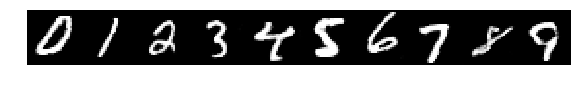

INFO:tensorflow:global_step/sec: 70.087
INFO:tensorflow:Saving model with global step 42951 (= 50 epochs) to disk.
INFO:tensorflow:complete training...


In [10]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with sv.managed_session(config=sess_config) as sess:
  tf.logging.info('Start Session.')
  
  #sv.start_queue_runners(sess=sess)
  #tf.logging.info('Starting Queues.')
  
  num_batches_per_epoch = num_examples / FLAGS.batch_size
  
  # save loss values for plot
  losses = []
  for epoch in range(FLAGS.max_epochs+1):
    for j in range(int(num_batches_per_epoch)):
      start_time = time.time()
      if sv.should_stop():
        break

      for _ in range(FLAGS.k):
        mnist_batch = mnist.train.next_batch(FLAGS.batch_size)
        random_z = np.random.uniform(low=-1., high=1., size=[FLAGS.batch_size, model.z_dim])

        _, loss_D = sess.run([opt_D_op, model.loss_Discriminator],
                              feed_dict={model.mnist: mnist_batch[0],
                                         model.labels: mnist_batch[1],
                                         model.random_z: random_z,
                                         model.condition: mnist_batch[1]})
      _, _global_step, loss_G = sess.run([opt_G_op,
                                          sv.global_step,
                                          model.loss_Generator],
                                          feed_dict={model.random_z: random_z,
                                                     model.condition: mnist_batch[1]})    

      epochs = epoch + j / num_batches_per_epoch
      duration = time.time() - start_time


      if _global_step % FLAGS.print_steps == 0:
        examples_per_sec = FLAGS.batch_size / float(duration)
        print("Epochs: %.2f global_step: %d  loss_D: %g  loss_G: %g (%.1f examples/sec; %.2f sec/batch)"
                % (epochs, _global_step, loss_D, loss_G, examples_per_sec, duration))

        losses.append([epochs, loss_D, loss_G])

        # print sample data
        sample_random_z = np.random.uniform(low=-1., high=1., size=[model.y_dim, model.z_dim])
        sample_condition = np.eye(model.y_dim)      
        sample_data = sess.run(model.sample_data, feed_dict={model.random_z: sample_random_z,
                                                             model.condition: sample_condition})
        print_sample_data(sample_data)

      # write summaries periodically
      if _global_step % FLAGS.summary_steps == 0:
        summary_str = sess.run(summary_op, feed_dict={model.mnist: mnist_batch[0],
                                                      model.labels: mnist_batch[1],
                                                      model.random_z: random_z,
                                                      model.condition: mnist_batch[1]})
        sv.summary_computed(sess, summary_str)

      # save model checkpoint periodically
      if epoch != 0  and  epoch % FLAGS.save_epochs == 0  and  j == 0:
        tf.logging.info('Saving model with global step %d (= %d epochs) to disk.' % (_global_step, epoch))
        sv.saver.save(sess, sv.save_path, global_step=sv.global_step)
      if epoch == FLAGS.max_epochs:
        break
      
  tf.logging.info('complete training...')

# Plot loss functions

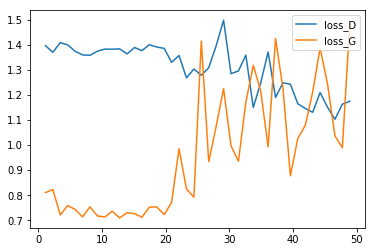

In [11]:
losses = np.asarray(losses)

plt.plot(losses[:,0], losses[:,1], label='loss_D')
plt.plot(losses[:,0], losses[:,2], label='loss_G')
plt.legend(loc='upper right')
plt.show()